In [ ]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

# 2D Logistic Regression

In [ ]:
import torch
import math
import numpy as np
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse

mpl.rcParams['figure.dpi'] = 300

def grid_gibbs(wgrid, dat, gt, delta, grid_dx):
    """gibbs measure for logistic loss and l2 regularization on a grid"""
    f = wgrid @ dat.T
    loss = -gt.reshape(1, -1) * f + np.log(1 + np.exp(f))
    regularizer = 0.5 * delta * (wgrid ** 2.0)
    density = np.exp(-loss.sum(axis=1) - regularizer.sum(axis=1))
    normalization = (grid_dx ** 2.0) * density
    return density / (normalization.sum())

def grid_loss(wgrid, dat, gt, delta, grid_dx):
    """logistic loss and l2 regularization on a grid"""
    f = wgrid @ dat.T
    loss = -gt.reshape(1, -1) * f + np.log(1 + np.exp(f))
    regularizer = 0.5 * delta * (wgrid ** 2.0)
    return loss.sum(axis=1) + regularizer.sum(axis=1)

def toydata(N=60, std1=1, std2=1.1, key=0):
    """Creates a seperable toy linear classification dataset"""
    np.random.seed(0)
    mid_index = math.floor(N/2)
    mu1 = np.stack([np.ones(mid_index), np.ones(N-mid_index)*5], axis=1)
    mu2 = np.stack([np.ones(mid_index)*+5, np.ones(N-mid_index)], axis=1)
    X = np.concatenate([
        np.random.normal(loc=mu1, scale=std1),
        np.random.normal(loc=mu2, scale=std2)])
    y = np.ones(N)
    y[mid_index:N] = 0
    # shuffle
    idx = np.arange(N)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]
    
    return jnp.array(X), jnp.array(y)

def plot_cov_ellipse(ax, mu, Sigma, nstd=1.5, label='', color='r', ls='-'):
    """Plots a covariance ellipse"""
    vals, vecs = np.linalg.eigh(Sigma)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    # Width and height are "full" widths, not radius
    width, height = 1.5 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=mu, width=width, height=height, angle=theta, fill=False, edgecolor=color, lw='3', ls=ls)
#    ellip1 = Ellipse(xy=mu, width=width+0.3, height=height+0.3, angle=theta, fill=False, edgecolor='g', lw='1', ls=ls)
#    ellip2 = Ellipse(xy=mu, width=width-0.3, height=height-0.3, angle=theta, fill=False, edgecolor='g', lw='1', ls=ls)
    ax.plot(mu[0], mu[1], 'o', color=color, ls=ls, label=label, markeredgecolor=color, markersize=10)
    ax.add_artist(ellip)
#    ax.add_artist(ellip1)
#    ax.add_artist(ellip2)

/Users/peterchang/Desktop/x01_pre_phd/googleresearch/Repos/bong/.bong_venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


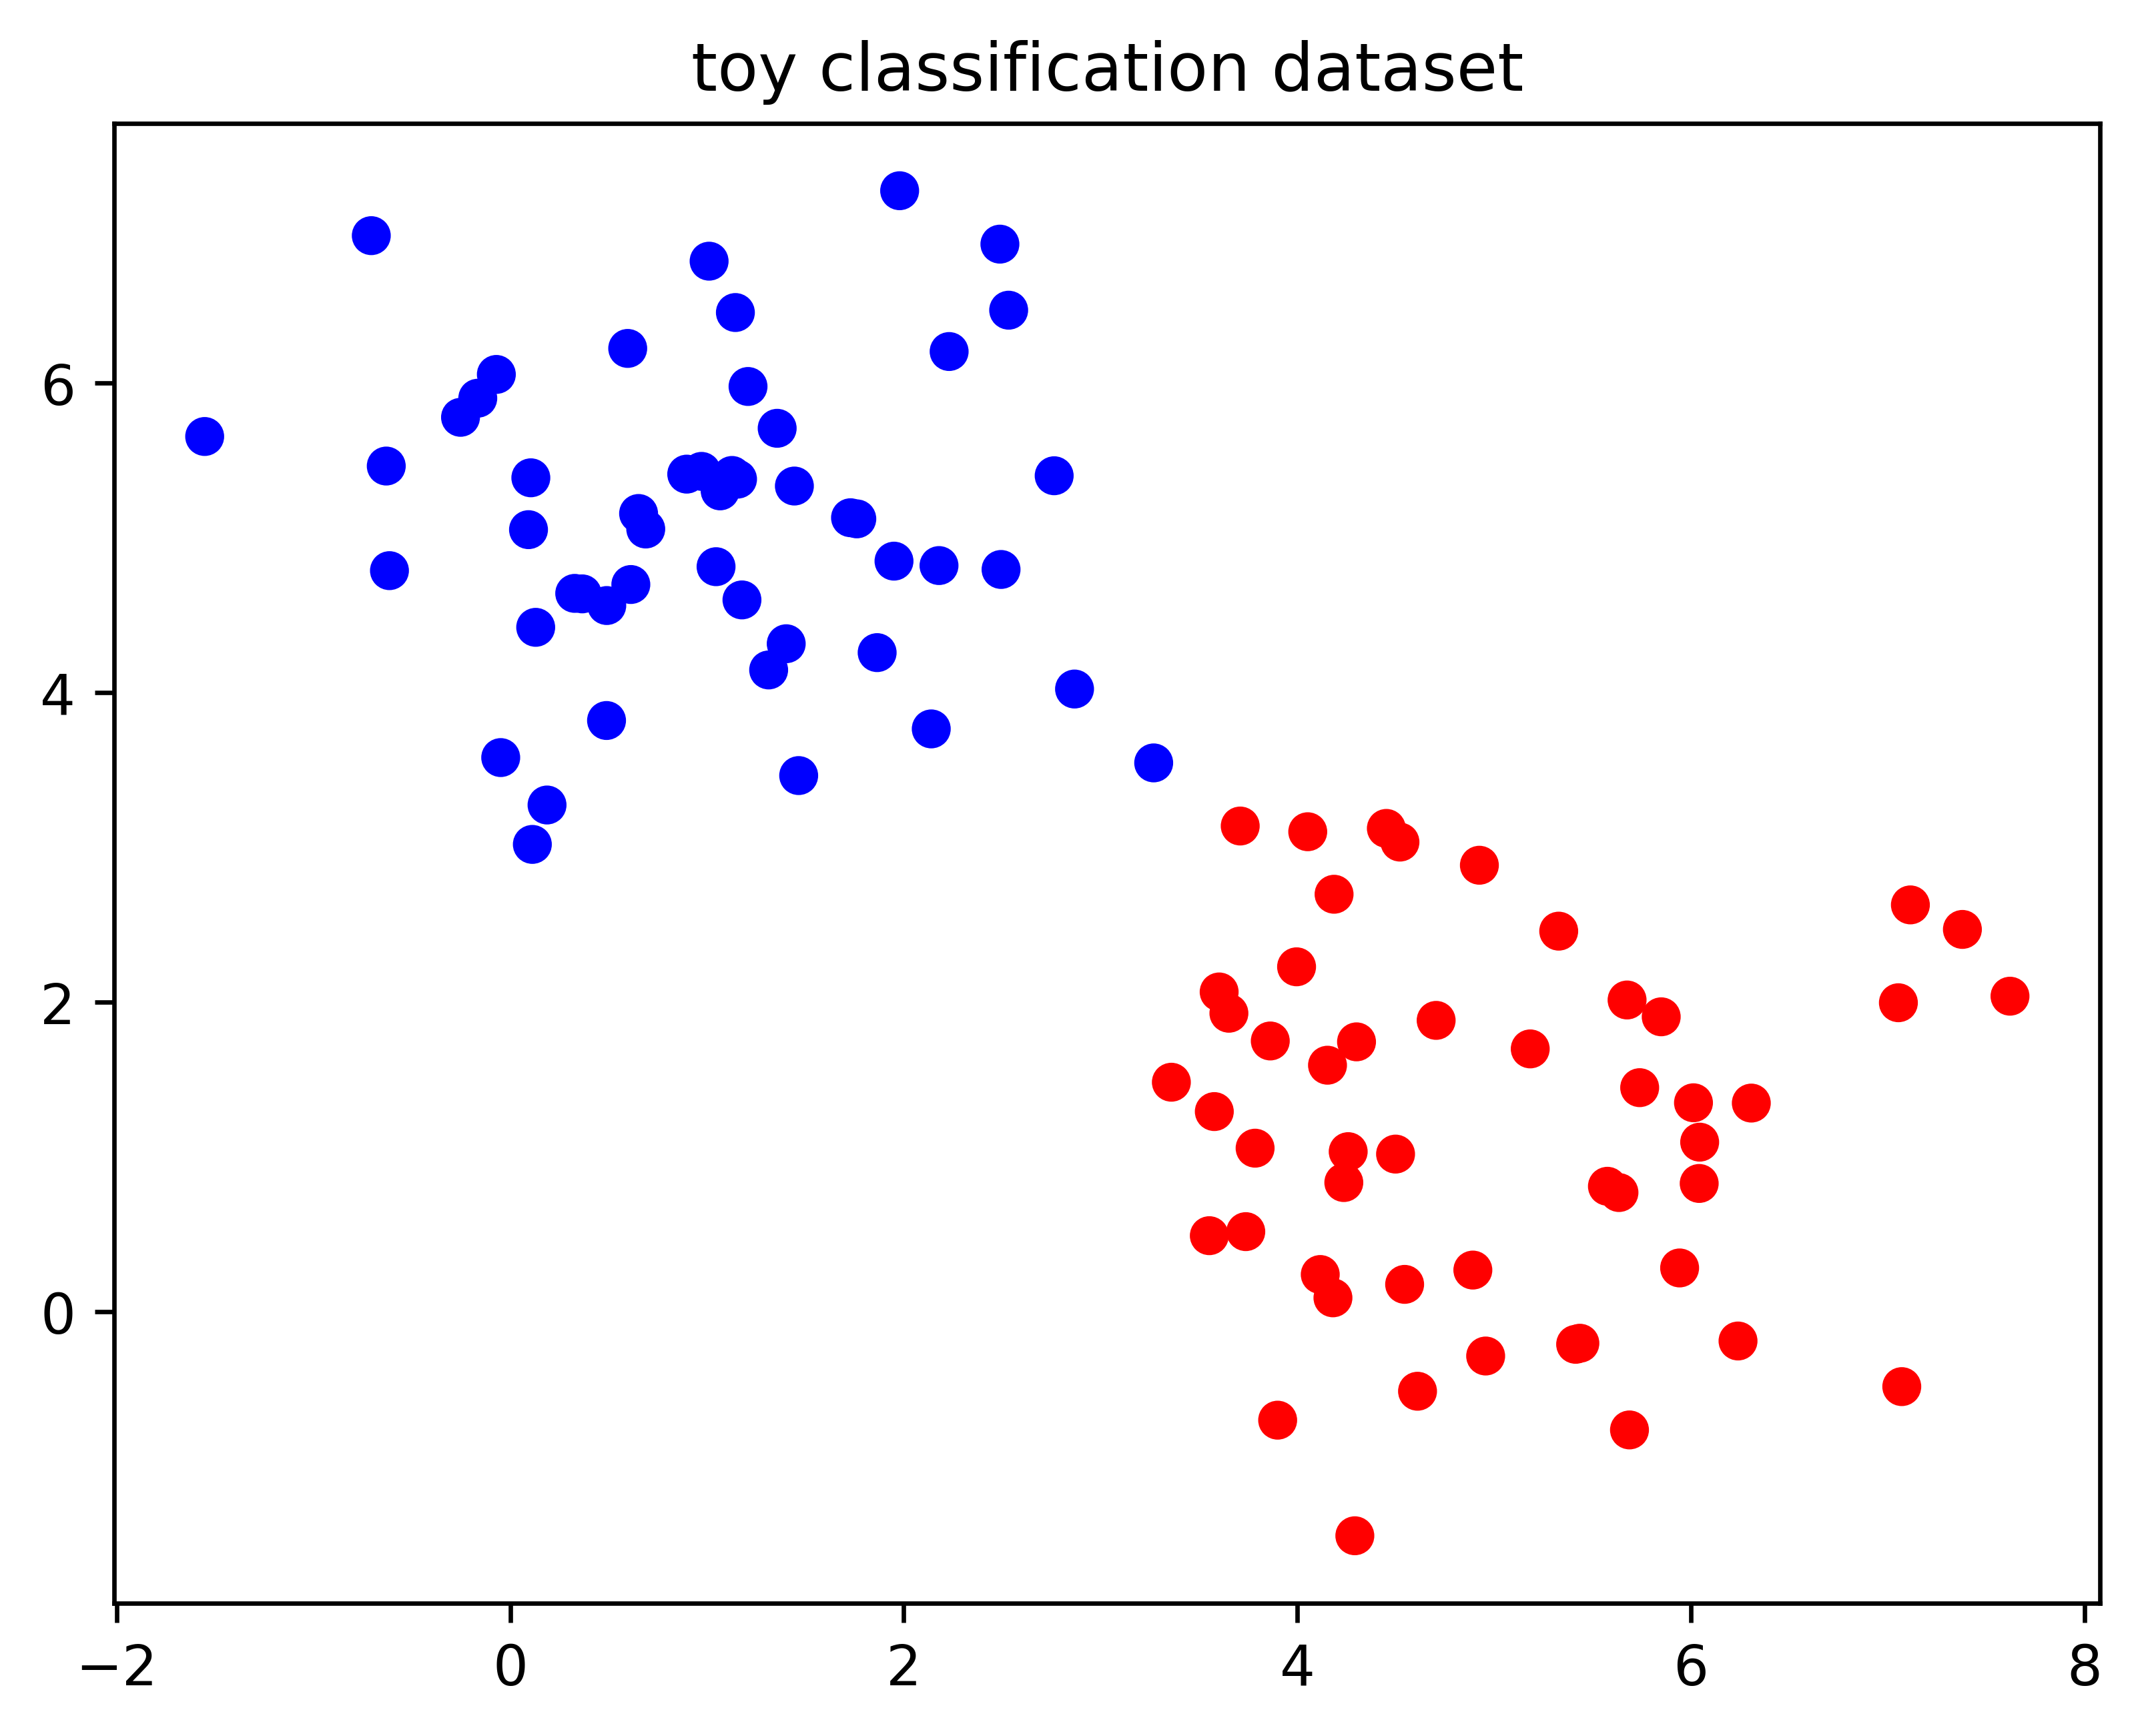

In [ ]:
N = 100 # number of data points
dat, gt = toydata(N, 1.0, 1.1,)

# plot dataset
fig = plt.figure()
colors = np.array([[1,0,0], [0,0,1]])
ax = fig.add_subplot(111)
ax.set_title('toy classification dataset')
ax.scatter(dat[:,0], dat[:, 1], c=colors[gt.astype('int'), :]);

In [ ]:
# import jax.numpy as jnp
# import matplotlib.pyplot as plt
# from sklearn import datasets

# n_train, n_val, n_test, noise = 1_000, 1_000, 100, 0.1
# X_tr, y_tr = datasets.make_moons(n_samples=n_train, noise=noise, random_state=0)
# X_val, y_val = datasets.make_moons(n_samples=n_val, noise=noise, random_state=1)
# X_te, y_te = datasets.make_moons(n_samples=n_test, noise=noise, random_state=2)
# # Cast to float
# X_tr, y_tr = jnp.array(X_tr), jnp.array(y_tr).astype(float)
# X_val, y_val = jnp.array(X_val), jnp.array(y_val).astype(float)
# X_te, y_te = jnp.array(X_te), jnp.array(y_te).astype(float)
# dat, gt = X_tr, y_tr

# plt.scatter(*X_tr.T, c=y_tr, cmap=plt.cm.Accent)
# plt.title("Generated half moons data");

In [ ]:
from flax import linen as nn
import optax
from typing import Sequence
import jax.random as jr

class MLP(nn.Module):
    features: Sequence[int]
    activation: nn.Module = nn.relu
    use_bias: bool = True

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1], use_bias=self.use_bias)(x)
        
        return x

In [ ]:
from typing import Callable, Union, Tuple, Any

import chex
from functools import partial
import jax
from jax import grad, jit, vmap
from jax.flatten_util import ravel_pytree
from jax.lax import scan
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp


linear_model = MLP(features = [1,], use_bias=False)
params = linear_model.init(jr.PRNGKey(0), jnp.ones(2,))
flat_params, unflatten_fn = ravel_pytree(params)
apply_fn = lambda w, x: linear_model.apply(unflatten_fn(w), jnp.atleast_1d(x))

In [ ]:
from bong.src import blr

# fg_bong = bong.fg_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=apply_fn,
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     empirical_fisher=True
# )

# fg_lbong = bong.fg_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=lambda w, x: jax.nn.sigmoid(apply_fn(w, x)),
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     linplugin=True,
# )

dlrg_blr = blr.dlrg_blr(
    init_mean=flat_params,
    init_cov=0.01,
    log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
    empirical_fisher=True
)

dlrg_lblr = blr.dlrg_blr(
    init_mean=flat_params,
    init_cov=0.01,
    log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
    emission_mean_function=lambda w, x: jax.nn.sigmoid(apply_fn(w, x)),
    emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
    linplugin=True,
)

# dg_bong = bong.dg_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=apply_fn,
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     empirical_fisher=True
# )

# dg_lbong = bong.dg_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=lambda w, x: jax.nn.sigmoid(apply_fn(w, x)),
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     linplugin=True,
# )

# fg_reparam_bong = bong.fg_reparam_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=apply_fn,
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     empirical_fisher=False
# )

# fg_reparam_lbong = bong.fg_reparam_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=lambda w, x: jax.nn.sigmoid(apply_fn(w, x)),
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     linplugin=True,
# )

# dg_reparam_bong = bong.dg_reparam_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=apply_fn,
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     empirical_fisher=True
# )

# dg_reparam_lbong = bong.dg_reparam_bong(
#     init_mean=flat_params,
#     init_cov=0.01,
#     log_likelihood=lambda mean, cov, y: -optax.sigmoid_binary_cross_entropy(mean, y),
#     emission_mean_function=lambda w, x: jax.nn.sigmoid(apply_fn(w, x)),
#     emission_cov_function=lambda w, x: 0.01 * jnp.eye(1),
#     linplugin=True,
# )

/Users/peterchang/Desktop/x01_pre_phd/googleresearch/Repos/bong/.bong_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from bong.util import run_rebayes_algorithm

# final_state, outputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     fg_bong,
#     dat,
#     gt,
# )

# final_lstate, loutputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     fg_lbong,
#     dat,
#     gt,
# )

with jax.disable_jit():
    final_dlrstate, outputs = run_rebayes_algorithm(
        jax.random.PRNGKey(0),
        dlrg_blr,
        dat[:10],
        gt[:10],
    )

# final_ldlrstate, loutputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     dlrg_lblr,
#     dat,
#     gt,
# )

# final_dstate, doutputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     dg_bong,
#     dat,
#     gt,
# )

# final_dlstate, dloutputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     dg_lbong,
#     dat,
#     gt,
# )

# final_rstate, routputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     fg_reparam_bong,
#     dat,
#     gt,
# )

# final_rlstate, rloutputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     fg_reparam_lbong,
#     dat,
#     gt,
# )

# final_drstate, droutputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     dg_reparam_bong,
#     dat,
#     gt,
# )

# final_drlstate, drloutputs = run_rebayes_algorithm(
#     jax.random.PRNGKey(0),
#     dg_reparam_lbong,
#     dat,
#     gt,
# )

prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag0: (2,)
prec_diag0: (2, 1)
prec_diag

In [ ]:
# mc_states = fg_bong.sample(jax.random.PRNGKey(0), final_state)
# mc_lstates = fg_lbong.sample(jax.random.PRNGKey(0), final_lstate)
mc_dlrstates = dlrg_blr.sample(jax.random.PRNGKey(0), final_dlrstate)
mc_ldlrstates = dlrg_lblr.sample(jax.random.PRNGKey(0), final_ldlrstate)
# mc_dstates = dg_bong.sample(jax.random.PRNGKey(0), final_dstate)
# mc_dlstates = dg_lbong.sample(jax.random.PRNGKey(0), final_dlstate)
# mc_rstates = fg_reparam_bong.sample(jax.random.PRNGKey(0), final_rstate)
# mc_rlstates = fg_reparam_lbong.sample(jax.random.PRNGKey(0), final_rlstate)
# mc_drstates = dg_reparam_bong.sample(jax.random.PRNGKey(0), final_drstate)
# mc_drlstates = dg_reparam_lbong.sample(jax.random.PRNGKey(0), final_drlstate)

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_states, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('FG-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_lstates, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('FG-L-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()

/Users/peterchang/Desktop/x01_pre_phd/googleresearch/Repos/bong/.bong_venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


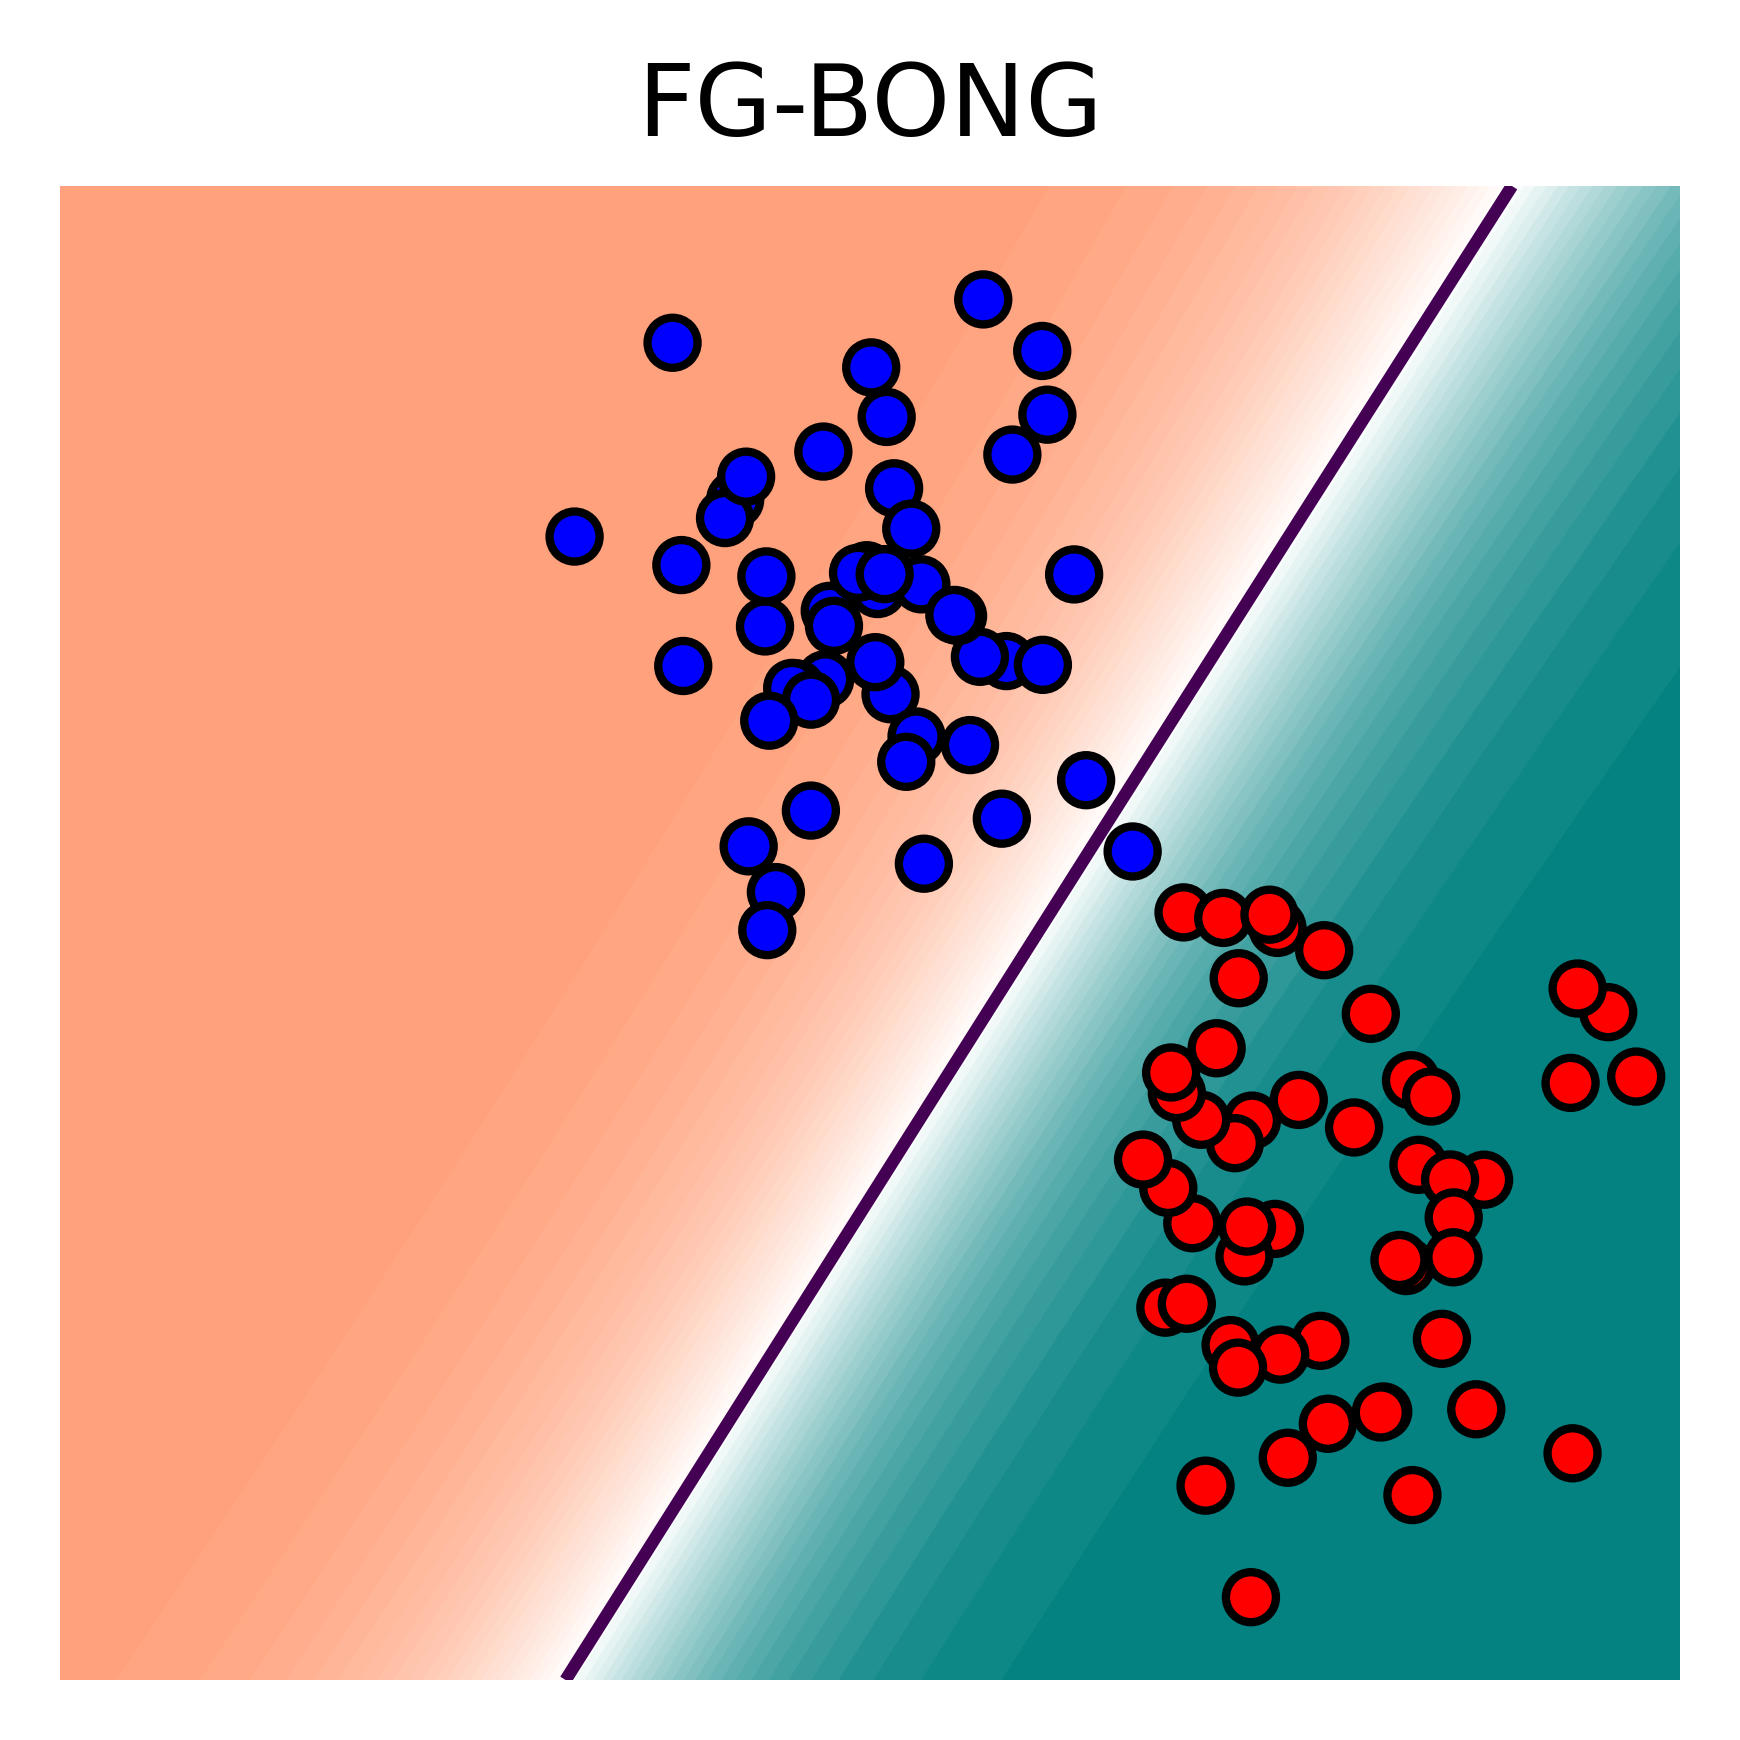

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
#colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

Nplot = 100
xaxis = jnp.linspace(-6, 8, Nplot)
yaxis = jnp.linspace(-2.0, 8, Nplot)
xx, yy = jnp.meshgrid(xaxis, yaxis)
Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_dlrstates, Xtest)
probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

fig, ax = plt.subplots(figsize=(3, 3))


colors = np.array([[1, 0, 0], [0, 0, 1]])
ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
ax.set_title('FG-BONG')
ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
ax.set_axis_off()

plt.tight_layout()
plt.show()

/Users/peterchang/Desktop/x01_pre_phd/googleresearch/Repos/bong/.bong_venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


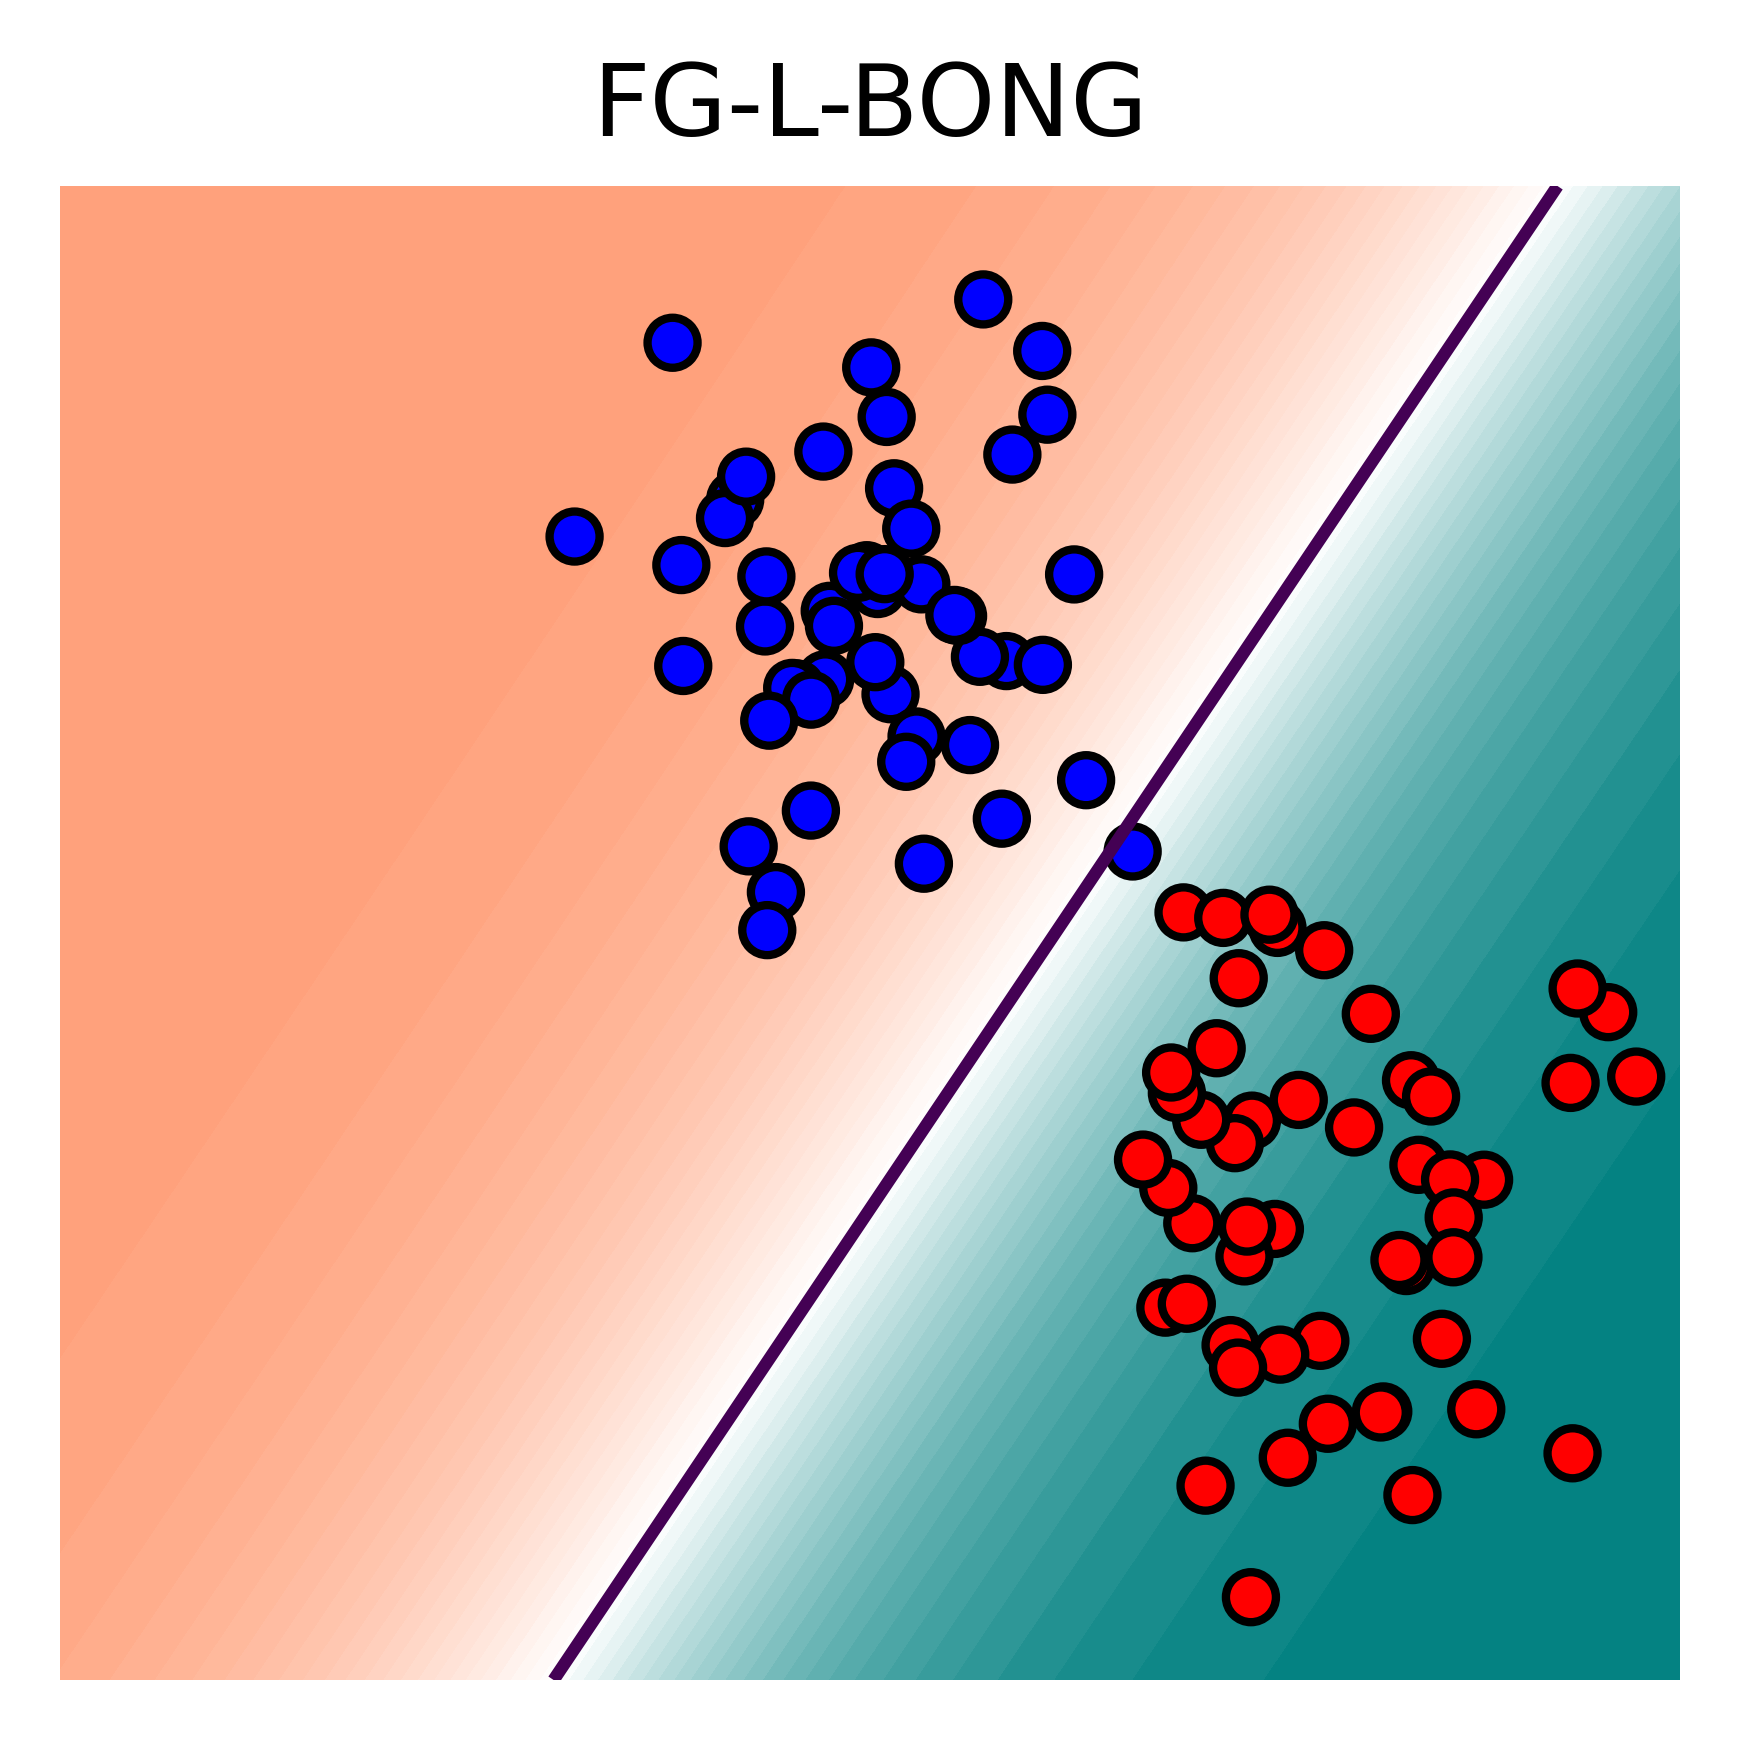

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
#colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

Nplot = 100
xaxis = jnp.linspace(-6, 8, Nplot)
yaxis = jnp.linspace(-2.0, 8, Nplot)
xx, yy = jnp.meshgrid(xaxis, yaxis)
Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_ldlrstates, Xtest)
probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

fig, ax = plt.subplots(figsize=(3, 3))

colors = np.array([[1, 0, 0], [0, 0, 1]])
ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
ax.set_title('FG-L-BONG')
ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_dstates, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('DG-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_dlstates, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('DG-L-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_rstates, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('FGR-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_rlstates, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('FGR-L-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_drstates, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('DGR-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# #colorlist = [ '#1976D2', '#F5F5F5', '#D32F2F' ]
# colorlist = [ '#008080', '#FFFFFF', '#FFA07A' ]
# mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256)

# Nplot = 100
# xaxis = jnp.linspace(-6, 8, Nplot)
# yaxis = jnp.linspace(-2.0, 8, Nplot)
# xx, yy = jnp.meshgrid(xaxis, yaxis)
# Xtest = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
    
# pred_logits = jax.vmap(jax.vmap(apply_fn, (None, 0)), (0, None))(mc_drlstates, Xtest)
# probs = jnp.mean(jax.nn.sigmoid(pred_logits), axis=0)

# fig, ax = plt.subplots(figsize=(3, 3))

# colors = np.array([[1, 0, 0], [0, 0, 1]])
# ax.contourf(xaxis, yaxis, probs.reshape(Nplot, Nplot), levels=50, cmap=mycmap)
# ax.contour(xaxis, yaxis, probs.reshape(Nplot, Nplot), [0.5])
# ax.set_title('DGR-L-BONG')
# ax.scatter(dat[:, 0], dat[:, 1], c=colors[gt.astype('int'), :], edgecolor='black')
# ax.set_axis_off()

# plt.tight_layout()
# plt.show()